# MiniRun6 LRS tutorial 4

In [1]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ./h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing ./h5flow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31716 sha256=7905be1bd637f3e58be226e3563121ef9a25c98524a5db41ce23396695adb358
  Stored in directory: /tmp/pip-ephem-wheel-cache-38efyax9/wheels/f1/5d/58/77983378fc64f41b62b695d5a44d952fa4c38d69af5c3ba1f2
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


Hello


In [2]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)

fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [3]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0

sipm_hits = f['light/sipm_hits/data']

In [4]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

In [5]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231
from scipy.ndimage import uniform_filter1d

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 5,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 3,
                pe_weight = 0.12,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins

In [6]:
baselines, rms = min_range_baseline(light_wvfms)
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]
sipm_hits = peak_finder(wvfm=cwvfms, noise=rms_calib)

In [7]:
# a function to get the 6 channels on the same EPCB
def get_epcb_channels(channel):
    if channel < 0 or channel > 63:
        return []  # invalid
    epcb = channel // 6
    return [(epcb * 6 + i) for i in range(6)]

# a function which takes the ADC and channel and gives a TPC number
def adc_channel_to_tpc(adc, channel):

    # use channels to determine if channel is in odd or even TPC
    if channel < 0 or channel > 63:
        return -1  # invalid
    if adc < 0 or adc > 7:
        return -1  # invalid
    tpc = adc + (channel // 32)
    tpc -= 1 if (adc % 2) else 0
    return tpc

# a function which takes a TPC number and gives a list of (adc, channel) tuples
def tpc_to_adc_channel(tpc):
    if tpc < 0 or tpc > 7:
        return []  # invalid
    channel_start = (tpc % 2) * 32
    channel_list = range(channel_start, channel_start + 32)
    channel_list = [ch for ch in channel_list if channel_status[tpc, ch] >= 0]

    adc_list = [tpc]
    if tpc % 2 == 0:
        adc_list.append(tpc + 1)
    else:
        adc_list.append(tpc - 1)

    adc_channel_list = [(adc, ch) for adc in adc_list for ch in channel_list]
    return adc_channel_list

In [8]:
def plot_waveform_with_hits(waveform, hits, evt, adc, chan):
    plt.figure(figsize=(10, 3))
    plt.plot(waveform)
    # for each hit in hits, plot a orange dot
    if np.any(hits):
        hit_idx = np.where(hits)[0]
        plt.scatter(hit_idx, waveform[hit_idx], label='hit', c='tab:orange')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(waveform)-1)
    plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
    plt.show()

def plot_waveforms_with_hits(light_wvfms, hits, channel_status, exclude_mod0=False,
                             event_ids=None, adc_list=None, channel_list=None,
                             max_nplots=None, require_hits=True):
    n_plots = 0

    if event_ids is None:
        event_ids = range(light_wvfms.shape[0])

    for evt in event_ids:
        samples_event = light_wvfms[evt]  # shape: (8, 64, 1000)
        hits_event = hits[evt]            # shape: (8, 64, N)
        rms_event = rms[evt]              # shape: (8, 64)
        found_hit = False
        if adc_list is None:
            adc_range = range(2, 8) if exclude_mod0 else range(8)
        else:
            adc_range = adc_list
        for adc in adc_range:
            if channel_list is None:
                channel_range = range(samples_event.shape[1])
            else:
                channel_range = channel_list
            for chan in channel_range:
                # Only plot if there are hits in this channel
                if require_hits and not np.any(hits_event[adc, chan, :]):
                    #print(f"No hits found for event {evt}")
                    continue
                if channel_status[adc, chan] == 0:
                    if max_nplots is not None and n_plots >= max_nplots:
                        return
                    plot_waveform_with_hits(samples_event[adc, chan, :],
                                            hits_event[adc, chan, :],
                                            evt, adc, chan)
                    n_plots += 1

Summing channels!

In [9]:
# these are generated in lrs_sanity_check/channel_sum_masks/ from the yaml file in proto_nd_flow

# import channel masks from npy files
tpc_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_TPC.npy')
print(tpc_sum.shape)
ttype_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_TrapType.npy')
print(ttype_sum.shape)
epcb_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_EPCB.npy')
print(epcb_sum.shape)
det_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_DET.npy')
print(det_sum.shape)  # (8, 64)

(8, 8, 64)
(16, 8, 64)
(64, 8, 64)
(128, 8, 64)


In [10]:
def plot_all_masks_single(masks, channel_status, title):
  n_masks, n_adc, n_channel = masks.shape
  combined = np.full((n_adc, n_channel), np.nan)  # set all to nan for transparency

  # For each mask, set the value to its index where mask is nonzero
  for idx in range(n_masks):
    combined[masks[idx] != 0] = idx

  # use custom color map
  cmap = cm.get_cmap('viridis', n_masks)
  cmap.set_bad(color='w')
  plt.figure(figsize=(20, 4))
  im = plt.imshow(combined, cmap=cmap, aspect='auto')
  plt.colorbar(im, label='Mask Index')
  plt.xlabel('Channel')
  plt.ylabel('ADC')
  plt.xticks(np.arange(0, 64, 1) - 0.5, labels=np.arange(0, 64, 1))
  plt.yticks(np.arange(0, 8, 1) - 0.5, labels=np.arange(0, 8, 1))
  plt.grid(which='both', linewidth=0.5, alpha=0.5, color='white')

  # Add numbers to the center of each bin
  for i in range(n_adc):
    for j in range(n_channel):
      if not np.isnan(combined[i, j]):
        plt.text(j, i, int(combined[i, j]), ha='center', va='center', color='r', fontsize=8)

  # Add markers for channel_status == 1 and channel_status == 2
  '''
  y, x = np.where(channel_status == 1)
  plt.scatter(x, y, color='red', marker='o', label='Dead', edgecolors='w')
  y, x = np.where(channel_status == 2)
  plt.scatter(x, y, color='w', marker='o', label='Baseline', edgecolors='k')
  plt.legend(loc='upper right')
  '''
  plt.title(title)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_1524192/4201340575.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n_masks)


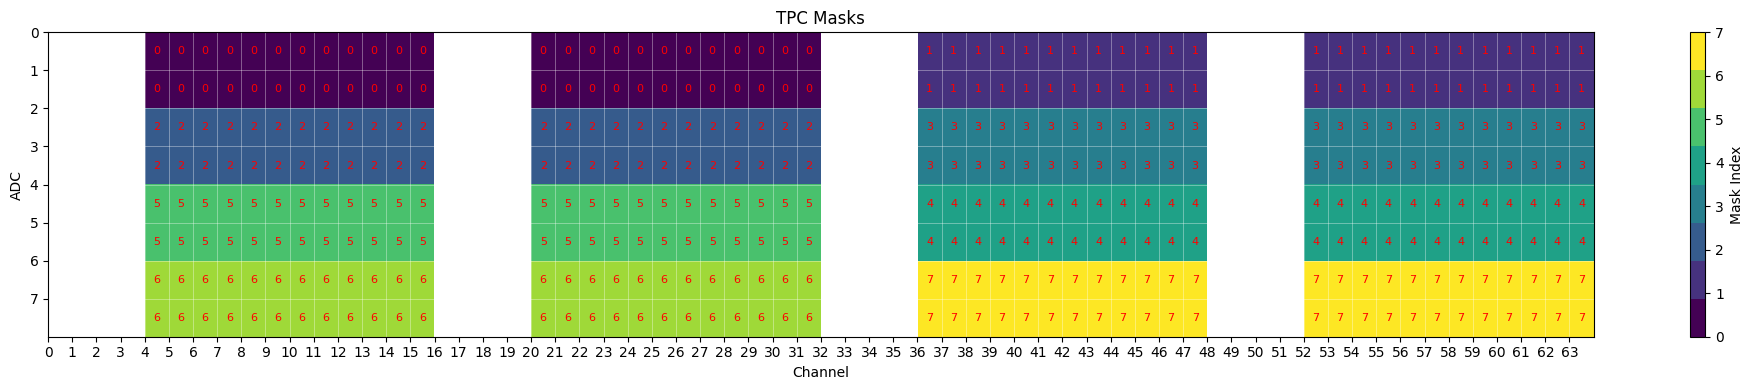

/tmp/ipykernel_1524192/4201340575.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n_masks)


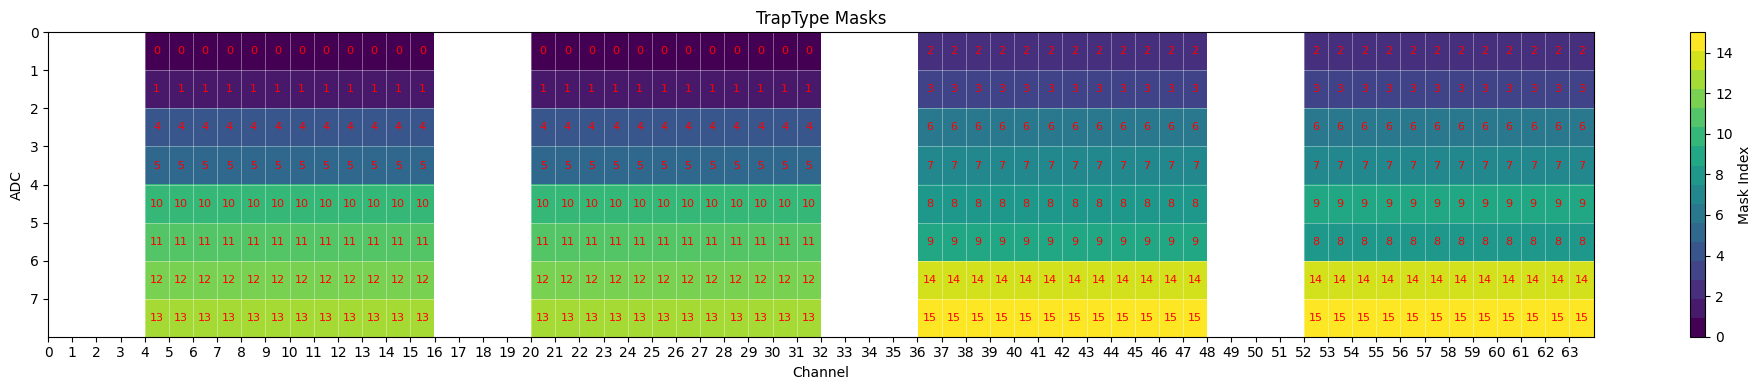

In [11]:
# all the channels in a TPC
plot_all_masks_single(tpc_sum, channel_status, "TPC Masks")
# all the ACLs in a TPC and all the LCMs in a TPC
plot_all_masks_single(ttype_sum, channel_status, "TrapType Masks")

/tmp/ipykernel_1524192/4201340575.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n_masks)


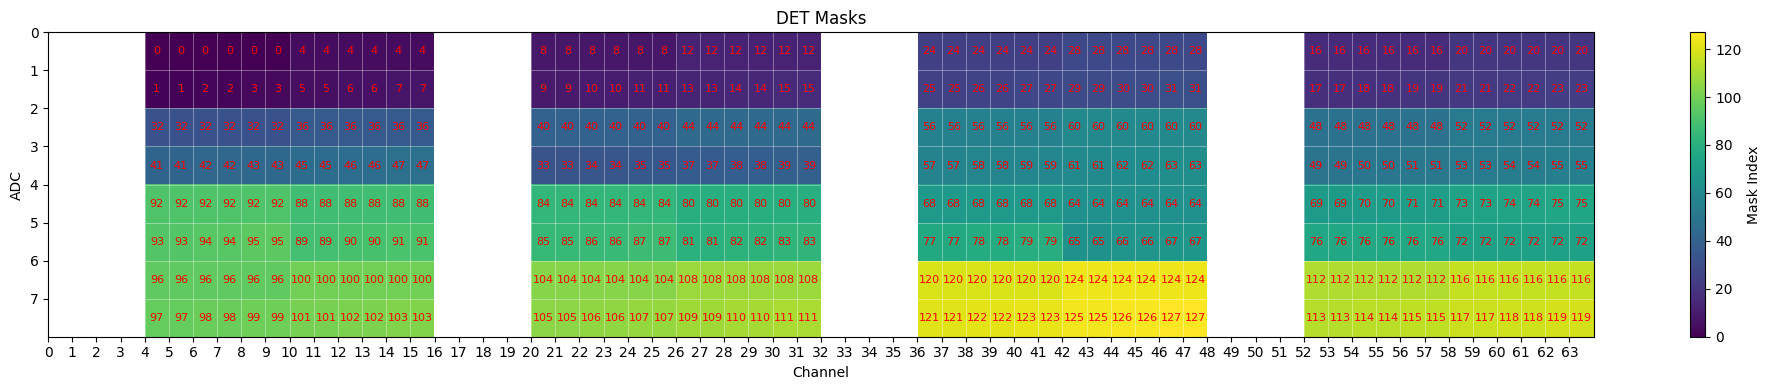

/tmp/ipykernel_1524192/4201340575.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n_masks)


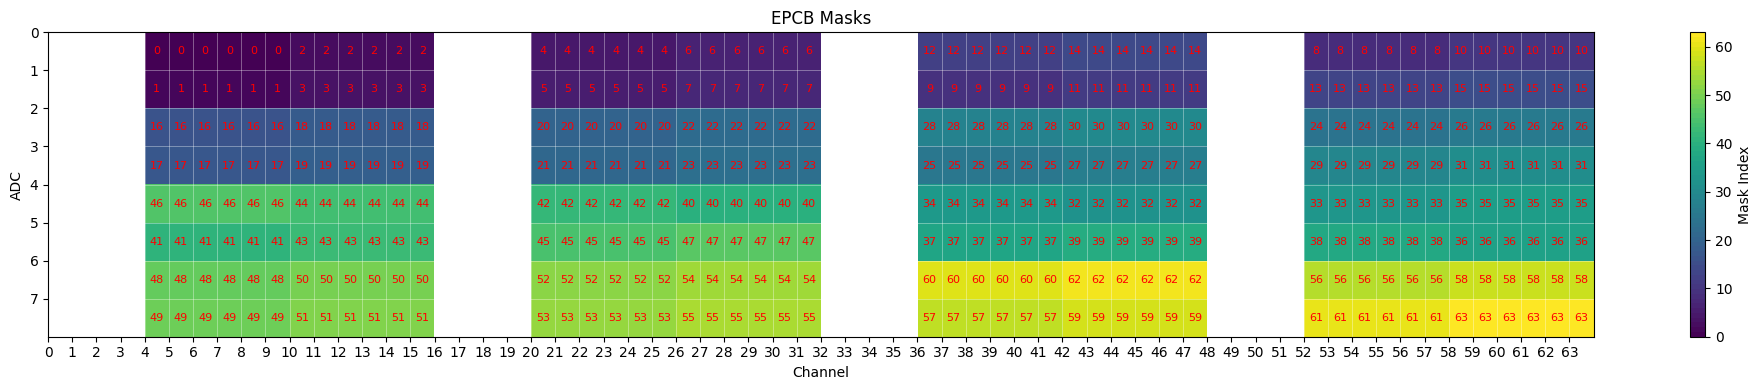

In [12]:
# each detector (ACL and LCM)
plot_all_masks_single(det_sum, channel_status, "DET Masks")
# each EPCB (ACL and LCM-group)
plot_all_masks_single(epcb_sum, channel_status, "EPCB Masks")

In [13]:
# sum the channels wvfms and rms by the DET masks
det_wvfms = np.zeros((light_wvfms.shape[0], det_sum.shape[0], light_wvfms.shape[3]))
det_rms = np.zeros((light_wvfms.shape[0], det_sum.shape[0]))
for i in range(det_sum.shape[0]):
    mask = det_sum[i] != 0
    det_wvfms[:, i, :] = np.sum(cwvfms[:, mask, :], axis=1)
    det_rms[:, i] = np.sqrt(np.sum(rms_calib[:, mask]**2, axis=1))
print(det_wvfms.shape)
print(det_rms.shape)

sum_hits = peak_finder(wvfm=det_wvfms, noise=det_rms)
print(sum_hits.shape)

(101, 128, 1000)
(101, 128)
(101, 128, 1000)


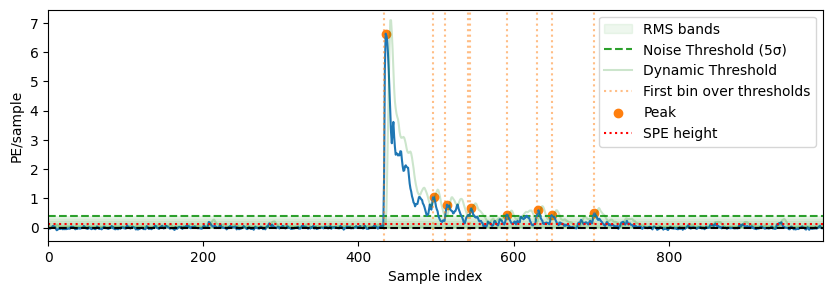

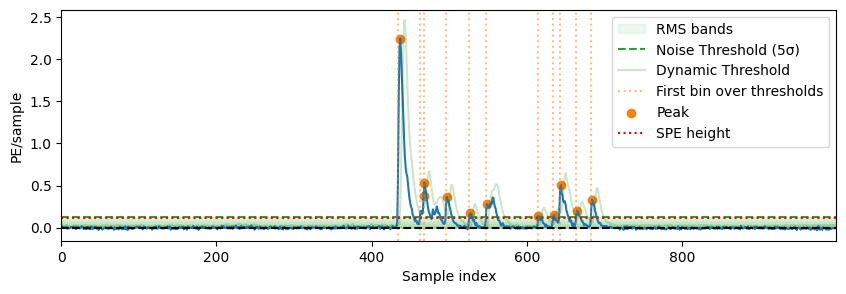

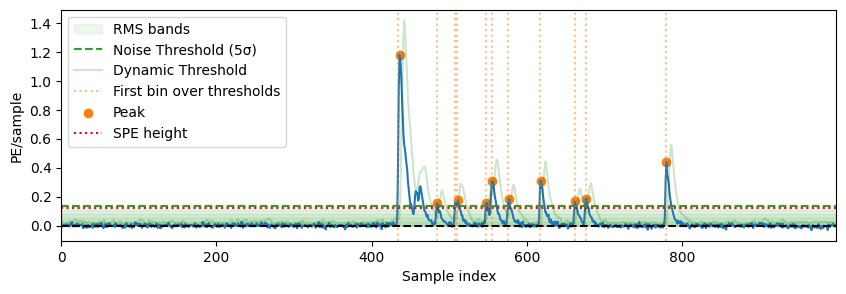

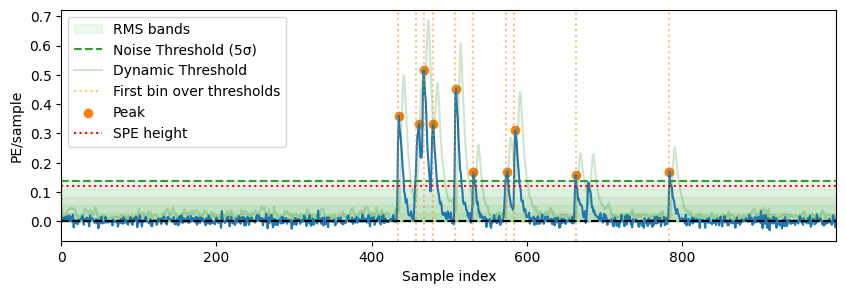

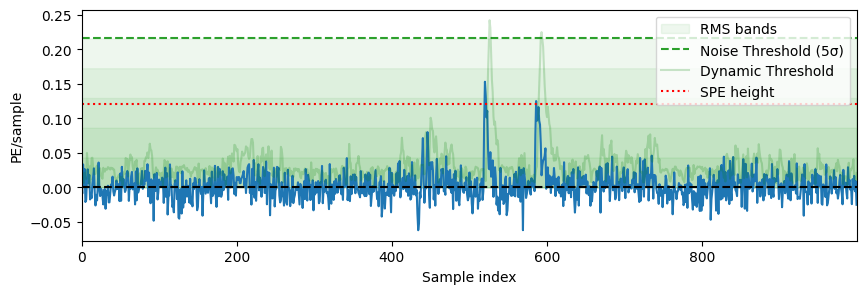

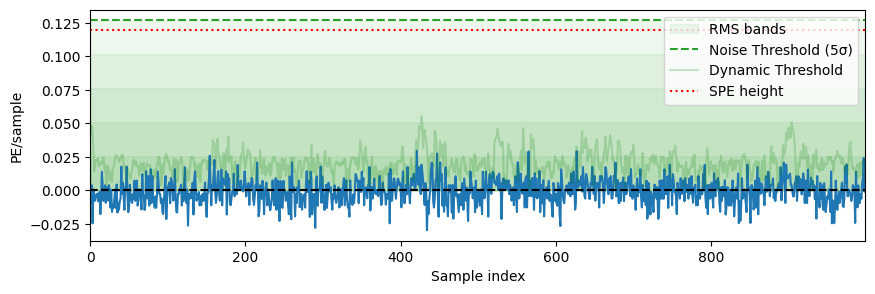

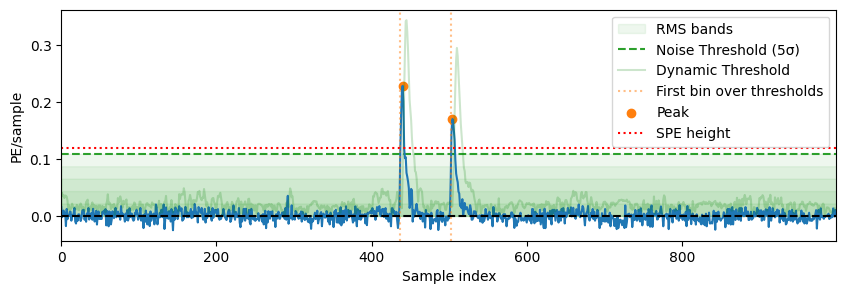

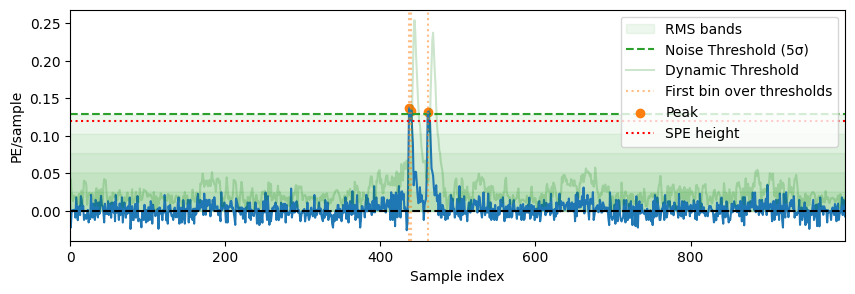

In [19]:
from scipy.ndimage import uniform_filter1d

def plot_waveform_with_hit_finder(wvfm, noise,
                                  n_noise_factor,
                                  n_bins_rolled,
                                  n_sqrt_rt_factor,
                                  pe_weight=0.12):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])

    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average

    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)

    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]

    # check 5 bins after first_bins_over and add argmax
    peak_bins = np.zeros_like(wvfm, dtype=bool)
    first_bins_indices = np.where(first_bins_over)
    for idx in zip(*first_bins_indices):
        start_idx = idx[-1]
        end_idx = min(start_idx + 5, wvfm.shape[-1])
        peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
        peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    hits = np.where(peak_bins)[-1] if np.any(peak_bins) else np.array([])

    plt.figure(figsize=(10, 3))
    n_rms = 5
    for k in range(1, n_noise_factor + 1):
        plt.fill_between(
            np.arange(len(wvfm)),
            0 * noise,
            k * noise,
            color='tab:green', alpha=0.08, label=f'RMS bands' if k == 1 else None
        )
    plt.axhline(n_rms * noise, color='tab:green', label=f'Noise Threshold ({n_rms}σ)', linestyle='--')
    plt.plot(wvfm)
    plt.plot(dynamic_threshold, label='Dynamic Threshold', color='green', alpha=0.2)
    # for each hit in hits, plot a orange dot
    if np.any(hits):
        for i, bin in enumerate(first_bins_indices[0]):
            label = f'First bin over thresholds' if i == 0 else None
            plt.axvline(bin, color='tab:orange', linestyle=':',
                        alpha=0.5, label=label)
        plt.scatter(hits, wvfm[hits], label='Peak', c='tab:orange')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(pe_weight, color='r', linestyle=':', label='SPE height')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(wvfm)-1)
    plt.show()

# example usage
evt = 3
det_indices = [48, 49, 50, 51, 52, 53, 54, 55]
for det_index in det_indices:
    plot_waveform_with_hit_finder(wvfm=det_wvfms[evt, det_index],
                                  noise=det_rms[evt, det_index],
                                  n_noise_factor=5,
                                  n_bins_rolled=5,
                                  n_sqrt_rt_factor=3,
                                  pe_weight=0.12)